## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

__NB:__ `conda install -c r rpy2=2.8.6 -f`
rpy2 needs to be a specific version to work in the ipython notebook.

This is the code to do the abc in R, it's useful for debugging.
```
%%R -i PRIOR,prior_args
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[prior_args]), PRIOR[,7], nval=2, tols=c(.5), method="rejection")
print(summary(cv.res.reg))
#plot(cv.res.reg)
print(cv.res.reg)
```

In [557]:
%matplotlib inline
%load_ext rpy2.ipython

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)

import os
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyparallel as ipp
import itertools
import random
import glob
import scipy
import rpy2.interactive as r
import rpy2.interactive.packages
import datetime
import time

from ipyrad.assemble.util import progressbar 
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import linregress

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)
ONED_DIR = GIMME_DIR + "1d_sims/"
TWOD_DIR = GIMME_DIR + "2d_sims/"

## Set up the link to ipcluster and create a loadbalanced view
## Need to run this externally, and wait for a little bit.
## `ipcluster start -n 40 --profile gimmeCV
ipyclient = ipp.Client(profile="gimmeCV")
print(len(ipyclient), 'cores')
thview = ipyclient.load_balanced_view()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
(40, 'cores')


In [3]:
## A function to return RMSE and R
def get_stats(tr, est):
    tr = np.array(tr).flatten()

    rms = sqrt(mean_squared_error(tr, est))
    r = np.corrcoef(np.vstack((tr, est)))[1,0]

    return rms, r

In [466]:
def call_abc(REF_TABLE, model, param, model_args, NCV=10):
    import pandas as pd
    import rpy2.interactive as r
    import rpy2.interactive.packages
    from rpy2 import robjects
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()

    r.packages.importr("abc")
    abc = r.packages.packages.abc

    ## Read in the prior
    ## Return the prior as a huge df
    PRIOR = pd.read_csv(REF_TABLE, sep="\t")

    cvresults = abc.cv4abc(PRIOR[param], PRIOR[model_args[model]], nval=NCV, tols=robjects.r["c"](0.01, 0.05), method="rejection")
    ## results_dict[model][param] = cvresults
    return cvresults


## Gather all the simulations into one huge simout file

In [502]:
## Three options
##  ONEPER          - Randomly select only one line per file (one sample from the
##                    entire temporal history of the community).
##  REGULARIZE      - Normalize all pi/dxy bins so they are proportional and not counts.
##                    This normalization routine makes loading the file much slower.
##  DROPEQUILIBSIMS - Remove all the extra simulations at equilibrium because it fucks up the prior.
def gather_simouts(SIMOUT_DIR, oneper=True, regularize=False, subset=False):
    ONEPER = oneper
    REGULARIZE = regularize
    DROPEQUILIBSIMS = True
    ## For making a small dataset for testing so it doesn't take forever
    SUBSET = subset

    filename = "priors.txt"
    if REGULARIZE:
        filename = "normed_priors.txt"
    REF_TABLE = os.path.join(SIMOUT_DIR, filename)
    outfile = open(REF_TABLE, "w")


    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])

    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        try:
            for line in lines:
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
        except:
            print("Error in file {}".format(f))
        ## Only choose one step per simulation?
        if lines and ONEPER:
            try:
                new_lines = [random.choice(new_lines)]
                new_lines = [x.strip() + "\n" for x in new_lines]
            except:
                ## Sometimes you get a file that's all sims at eq, so this is blank
                continue

        ## DO or don't regularlize the histograms
        if REGULARIZE:
            tmp_lines = []
            for line in new_lines:
                try:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = "\t".join(tmp) + "\n"
                    if "NaN" in line:
                        ## Sometimes something screws up so just drop it
                        continue
                    else:
                        tmp_lines.append(line)
                except:
                    continue
            new_lines = tmp_lines
        ## Don't write blanks
        if new_lines:
            numsims += len(new_lines)
            outfile.write("".join(new_lines))
        if SUBSET:
            if numsims > 20000:
                break
    outfile.close()
    print("Processed {} simulations.".format(numsims))
    return REF_TABLE

ONED_PRIOR_INTS = gather_simouts(ONED_DIR, oneper=True, regularize=False, subset=False)
TWOD_PRIOR_INTS = gather_simouts(TWOD_DIR, oneper=True, regularize=False, subset=False)
ONED_PRIOR_NORMED = gather_simouts(ONED_DIR, oneper=True, regularize=True, subset=False)
TWOD_PRIOR_NORMED = gather_simouts(TWOD_DIR, oneper=True, regularize=True, subset=False)


Error in file /home/isaac/gimmeSAD/1d_sims/K_9849-C_0.0151989311461_1503251271.74/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_9751-C_0.00404822341049_1503250091.77/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_6892-C_0.00941981525278_1503251720.04/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_9855-C_0.0442117173795_1503251720.04/sumstats.txt
Processed 14640 simulations.
Error in file /home/isaac/gimmeSAD/2d_sims/K_8813-C_0.00147228331305_1505074753.84/sumstats.txt
Error in file /home/isaac/gimmeSAD/2d_sims/K_4962-C_0.00577051184512_1505076174.74/sumstats.txt
Processed 9465 simulations.
Error in file /home/isaac/gimmeSAD/1d_sims/K_9849-C_0.0151989311461_1503251271.74/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_9751-C_0.00404822341049_1503250091.77/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_6892-C_0.00941981525278_1503251720.04/sumstats.txt
Error in file /home/isaac/gimmeSAD/1d_sims/K_9855-C_0.0442117173795_1503251720.04/

## Walk through and perform CV for each parameter using each data configuration.
## Parallelized with ipcluster so it's much faster

In [492]:
## For the impatient, do them all at once forking w/ ipcluster
DO_NORMED = True
if DO_NORMED:
    ONED_PRIOR = ONED_PRIOR_NORMED
    TWOD_PRIOR = TWOD_PRIOR_NORMED
else:
    ONED_PRIOR = ONED_PRIOR_INTS
    TWOD_PRIOR = TWOD_PRIOR_INTS
    
models = ["Ma", "Mi", "Mai", "Mmi", "Mami"]
model_args = {"Ma":["shannon"],\
              "Mi":["bin_"+str(x) for x in range(0,10)],\
              "Mai":["shannon"] + ["bin_"+str(x) for x in range(0,10)],\
              "Mmi":["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)],\
              "Mami":["shannon"] + ["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)]}
params = ["K", "c", "%equil", "colrate", "extrate", "shannon"]

## Create the dict for holding results
cv_jobs = {}
alljobs = []
for model in models:
    
    ## Select the right prior for each model
    if "m" in model:
        PRIOR = TWOD_PRIOR
    else:
        PRIOR = ONED_PRIOR

    cv_jobs[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        ## print("Doing {} {}".format(model, param))
        cv_jobs[model][param] = thview.apply(call_abc, *[PRIOR, model, param, model_args, 100])
        alljobs.append(cv_jobs[model][param])

## Wait for all jobs to finish
start = time.time()
while 1:
    total = len(alljobs)
    ready = [i.ready() for i in alljobs]
    printstr = ' waiting   | {} |'
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(total, sum(ready), printstr.format(elapsed))
    time.sleep(0.1)
    if all(ready):
        break
print("done")

Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami
  [####################] 100%  waiting   | 0:05:02 | done


## Pull results out of the asyncs

### Which ones took the longest? Out of curiosity

In [493]:
## get results for each model/param combination
results_dict = {}
for model in models:
    results_dict[model] = {}
    for param in params:
        try:
            results_dict[model][param] = cv_jobs[model][param].result()
            print("{}\t{}\t{}\t{}".format(cv_jobs[model][param].elapsed, model, param, type(results_dict[model][param])))
        except Exception as inst:
            print("{} {} {}".format(model, param, inst))

15.847813	Ma	K	<class 'rpy2.robjects.vectors.ListVector'>
15.157618	Ma	c	<class 'rpy2.robjects.vectors.ListVector'>
15.037017	Ma	%equil	<class 'rpy2.robjects.vectors.ListVector'>
15.5767	Ma	colrate	<class 'rpy2.robjects.vectors.ListVector'>
14.603089	Ma	extrate	<class 'rpy2.robjects.vectors.ListVector'>
Ma shannon 'shannon'
81.818685	Mi	K	<class 'rpy2.robjects.vectors.ListVector'>
81.934387	Mi	c	<class 'rpy2.robjects.vectors.ListVector'>
81.038813	Mi	%equil	<class 'rpy2.robjects.vectors.ListVector'>
79.696714	Mi	colrate	<class 'rpy2.robjects.vectors.ListVector'>
78.575578	Mi	extrate	<class 'rpy2.robjects.vectors.ListVector'>
75.72695	Mi	shannon	<class 'rpy2.robjects.vectors.ListVector'>
91.926802	Mai	K	<class 'rpy2.robjects.vectors.ListVector'>
87.716216	Mai	c	<class 'rpy2.robjects.vectors.ListVector'>
82.544191	Mai	%equil	<class 'rpy2.robjects.vectors.ListVector'>
87.995564	Mai	colrate	<class 'rpy2.robjects.vectors.ListVector'>
89.512765	Mai	extrate	<class 'rpy2.robjects.vectors.ListV

## Do a bunch of nasty rpy2 stuff to get the data out

In [494]:

cv_dict = {}
for model in models:
    cv_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        cv_dict[model][param] = {}
        cvresults = results_dict[model][param]
        df_true = pandas2ri.ri2py(cvresults[cvresults.names.index('true')])
        df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('estim')])
        df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('')])
        tru = np.array(df_true).flatten()
        est = np.array(df_est).flatten()[:100]
        cv_dict[model][param]["true"] = tru
        cv_dict[model][param]["estim"] = est
        rms, r = get_stats(tru, est)
        cv_dict[model][param]["rms"] = rms
        cv_dict[model][param]["r"] = r


Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami


In [495]:
## Print the rms and r2 for each model x param

print("Model\tParam\tRMS\t\tR")
for model in models:
    for param in params:
        try:
            rms = cv_dict[model][param]["rms"]
            r2 = cv_dict[model][param]["r"]**2
            rms = format(rms, ".3f")
            r2 = format(r2, ".3f")
            print("{}\t{}\t{}\t{}".format(model, param, rms, r2))
        except:
            pass
    print("")

Model	Param	RMS		R
Ma	K	2294.647	0.227
Ma	c	0.013	0.095
Ma	%equil	0.192	0.744
Ma	colrate	0.014	0.034
Ma	extrate	0.003	0.220

Mi	K	2110.584	0.360
Mi	c	0.011	0.444
Mi	%equil	0.286	0.405
Mi	colrate	0.012	0.255
Mi	extrate	0.003	0.293
Mi	shannon	0.440	0.623

Mai	K	2198.411	0.367
Mai	c	0.009	0.578
Mai	%equil	0.240	0.638
Mai	colrate	0.009	0.485
Mai	extrate	0.003	0.333

Mmi	K	1603.819	0.643
Mmi	c	0.011	0.443
Mmi	%equil	0.329	0.351
Mmi	colrate	0.010	0.538
Mmi	extrate	0.002	0.676
Mmi	shannon	0.445	0.639

Mami	K	1495.775	0.661
Mami	c	0.009	0.585
Mami	%equil	0.185	0.767
Mami	colrate	0.010	0.547
Mami	extrate	0.002	0.671



## Define function to make the fancy plot

In [560]:
def plot_cv(model, cv_dict):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]
    
    for param, ax in zip(params, axarr):
        if "a" in model and param == "shannon":
            continue
        print(model, param),

        x = cv_dict[model][param]["true"]
        y = cv_dict[model][param]["estim"]
        
        xmin = ymin = min(x)
        xlim = ylim = max(x)

        RUN_NAME = param
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(cv_dict[model][param]["rms"])
        R2 = "R^2  {0:.4f}".format(cv_dict[model][param]["r"]**2)
        print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(x, y, marker=".", color='w', edgecolors='black', s=10)
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("Estimated {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        #ax.set_xlim(xmin, xlim)
        #ax.set_ylim(ymin, ylim)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        plt.gca().set_facecolor('white')
        ax.grid(False)

        ## Add RMSE and R^2 to plots
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(model, fontsize=13)


('Ma', 'K') ('RMSE 2294.6473', 'R^2  0.2269')
('Ma', 'c') ('RMSE 0.0133', 'R^2  0.0952')
('Ma', '%equil') ('RMSE 0.1916', 'R^2  0.7440')
('Ma', 'colrate') ('RMSE 0.0139', 'R^2  0.0338')
('Ma', 'extrate') ('RMSE 0.0028', 'R^2  0.2198')

('Mi', 'K') ('RMSE 2110.5839', 'R^2  0.3602')
('Mi', 'c') ('RMSE 0.0106', 'R^2  0.4442')
('Mi', '%equil') ('RMSE 0.2863', 'R^2  0.4054')
('Mi', 'colrate') ('RMSE 0.0116', 'R^2  0.2546')
('Mi', 'extrate') ('RMSE 0.0025', 'R^2  0.2934')
('Mi', 'shannon') ('RMSE 0.4401', 'R^2  0.6227')

('Mai', 'K') ('RMSE 2198.4109', 'R^2  0.3675')
('Mai', 'c') ('RMSE 0.0094', 'R^2  0.5779')
('Mai', '%equil') ('RMSE 0.2404', 'R^2  0.6376')
('Mai', 'colrate') ('RMSE 0.0092', 'R^2  0.4849')
('Mai', 'extrate') ('RMSE 0.0032', 'R^2  0.3330')

('Mmi', 'K') ('RMSE 1603.8191', 'R^2  0.6434')
('Mmi', 'c') ('RMSE 0.0106', 'R^2  0.4427')
('Mmi', '%equil') ('RMSE 0.3294', 'R^2  0.3514')
('Mmi', 'colrate') ('RMSE 0.0101', 'R^2  0.5377')
('Mmi', 'extrate') ('RMSE 0.0022', 'R^2  0.6763'

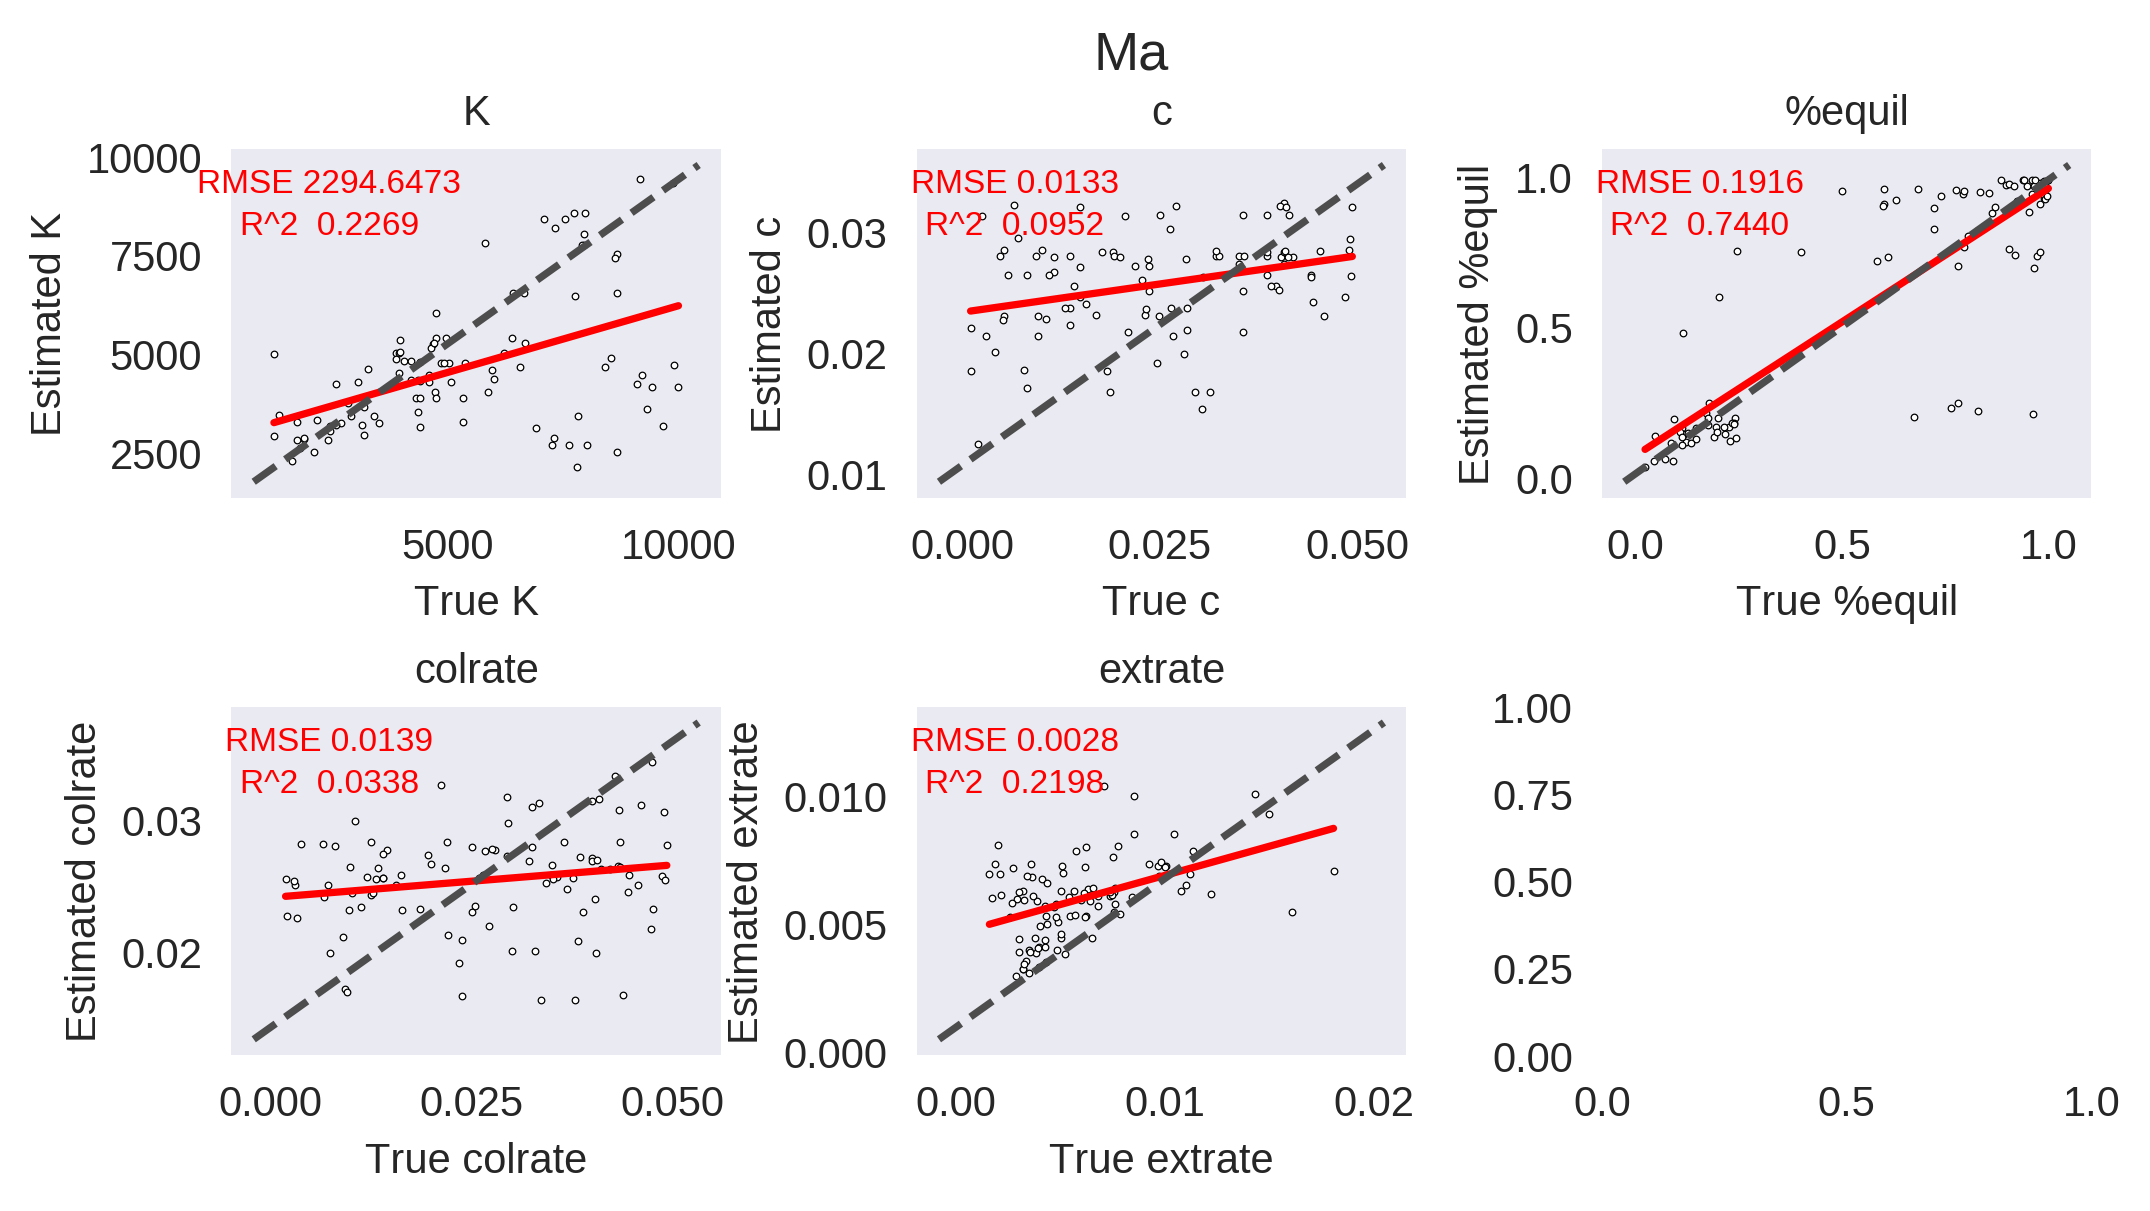

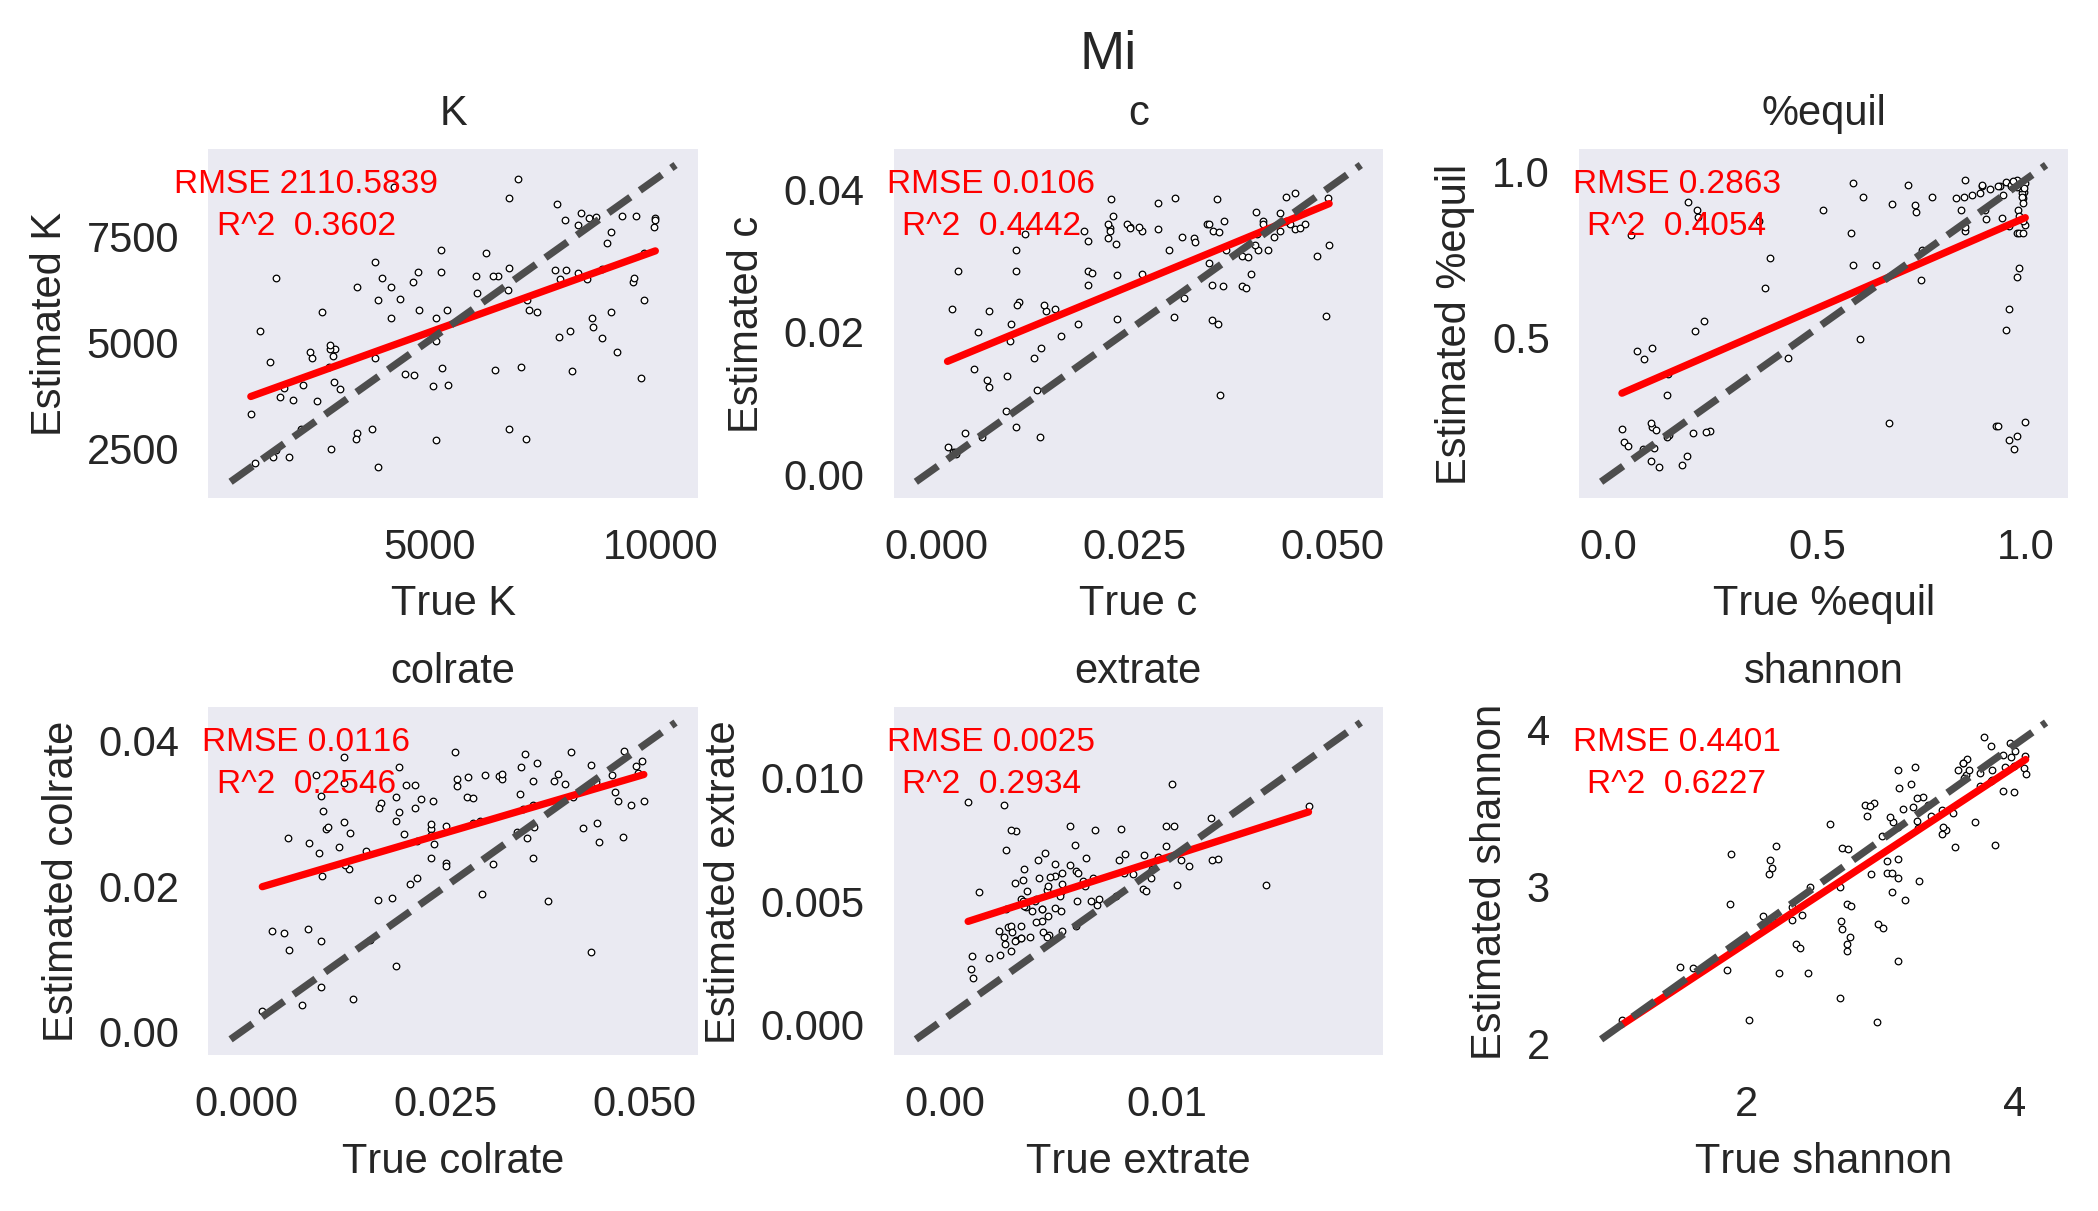

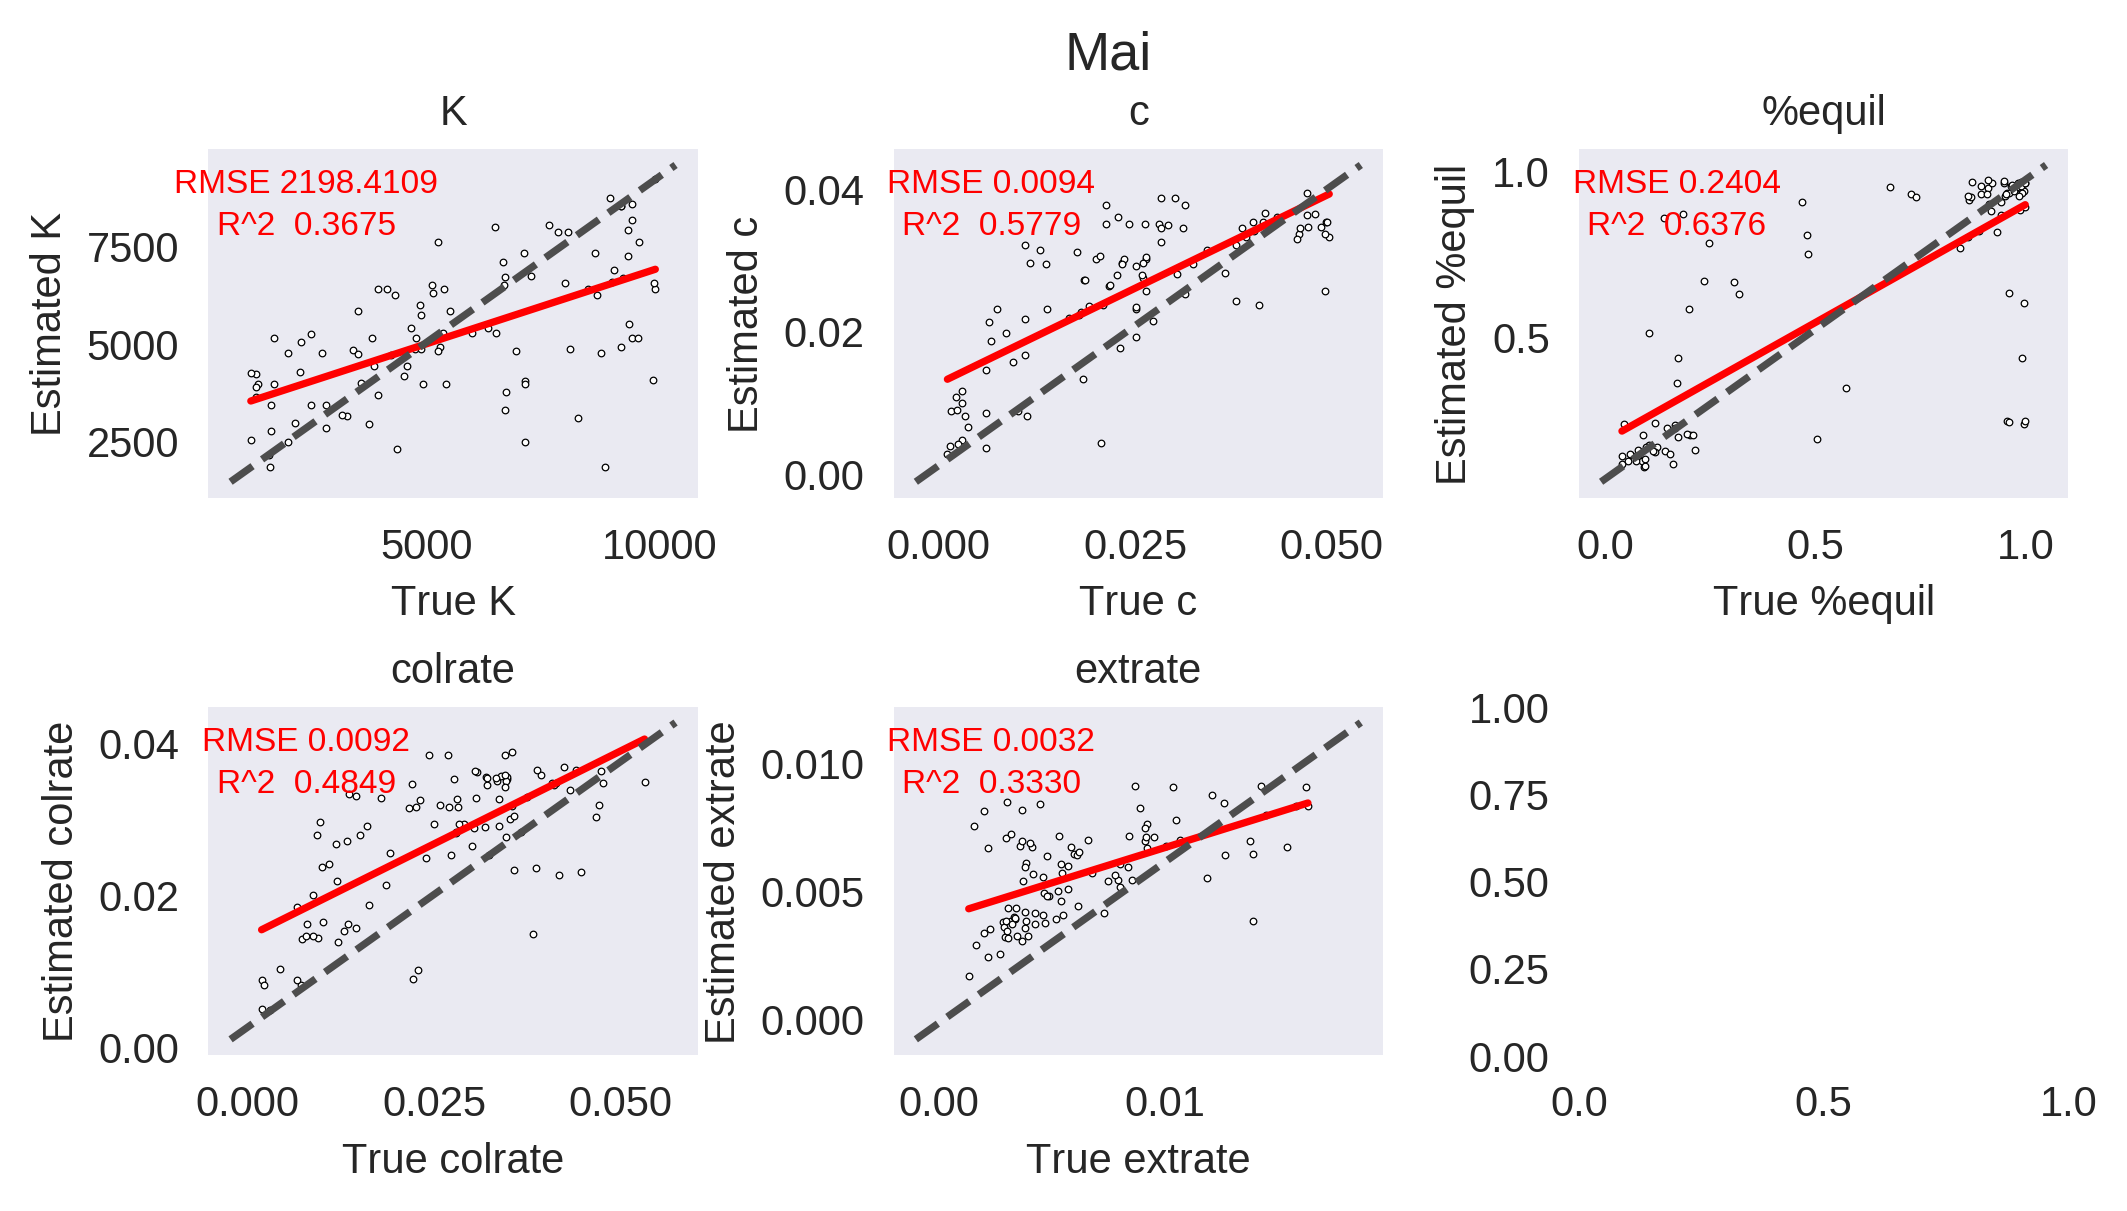

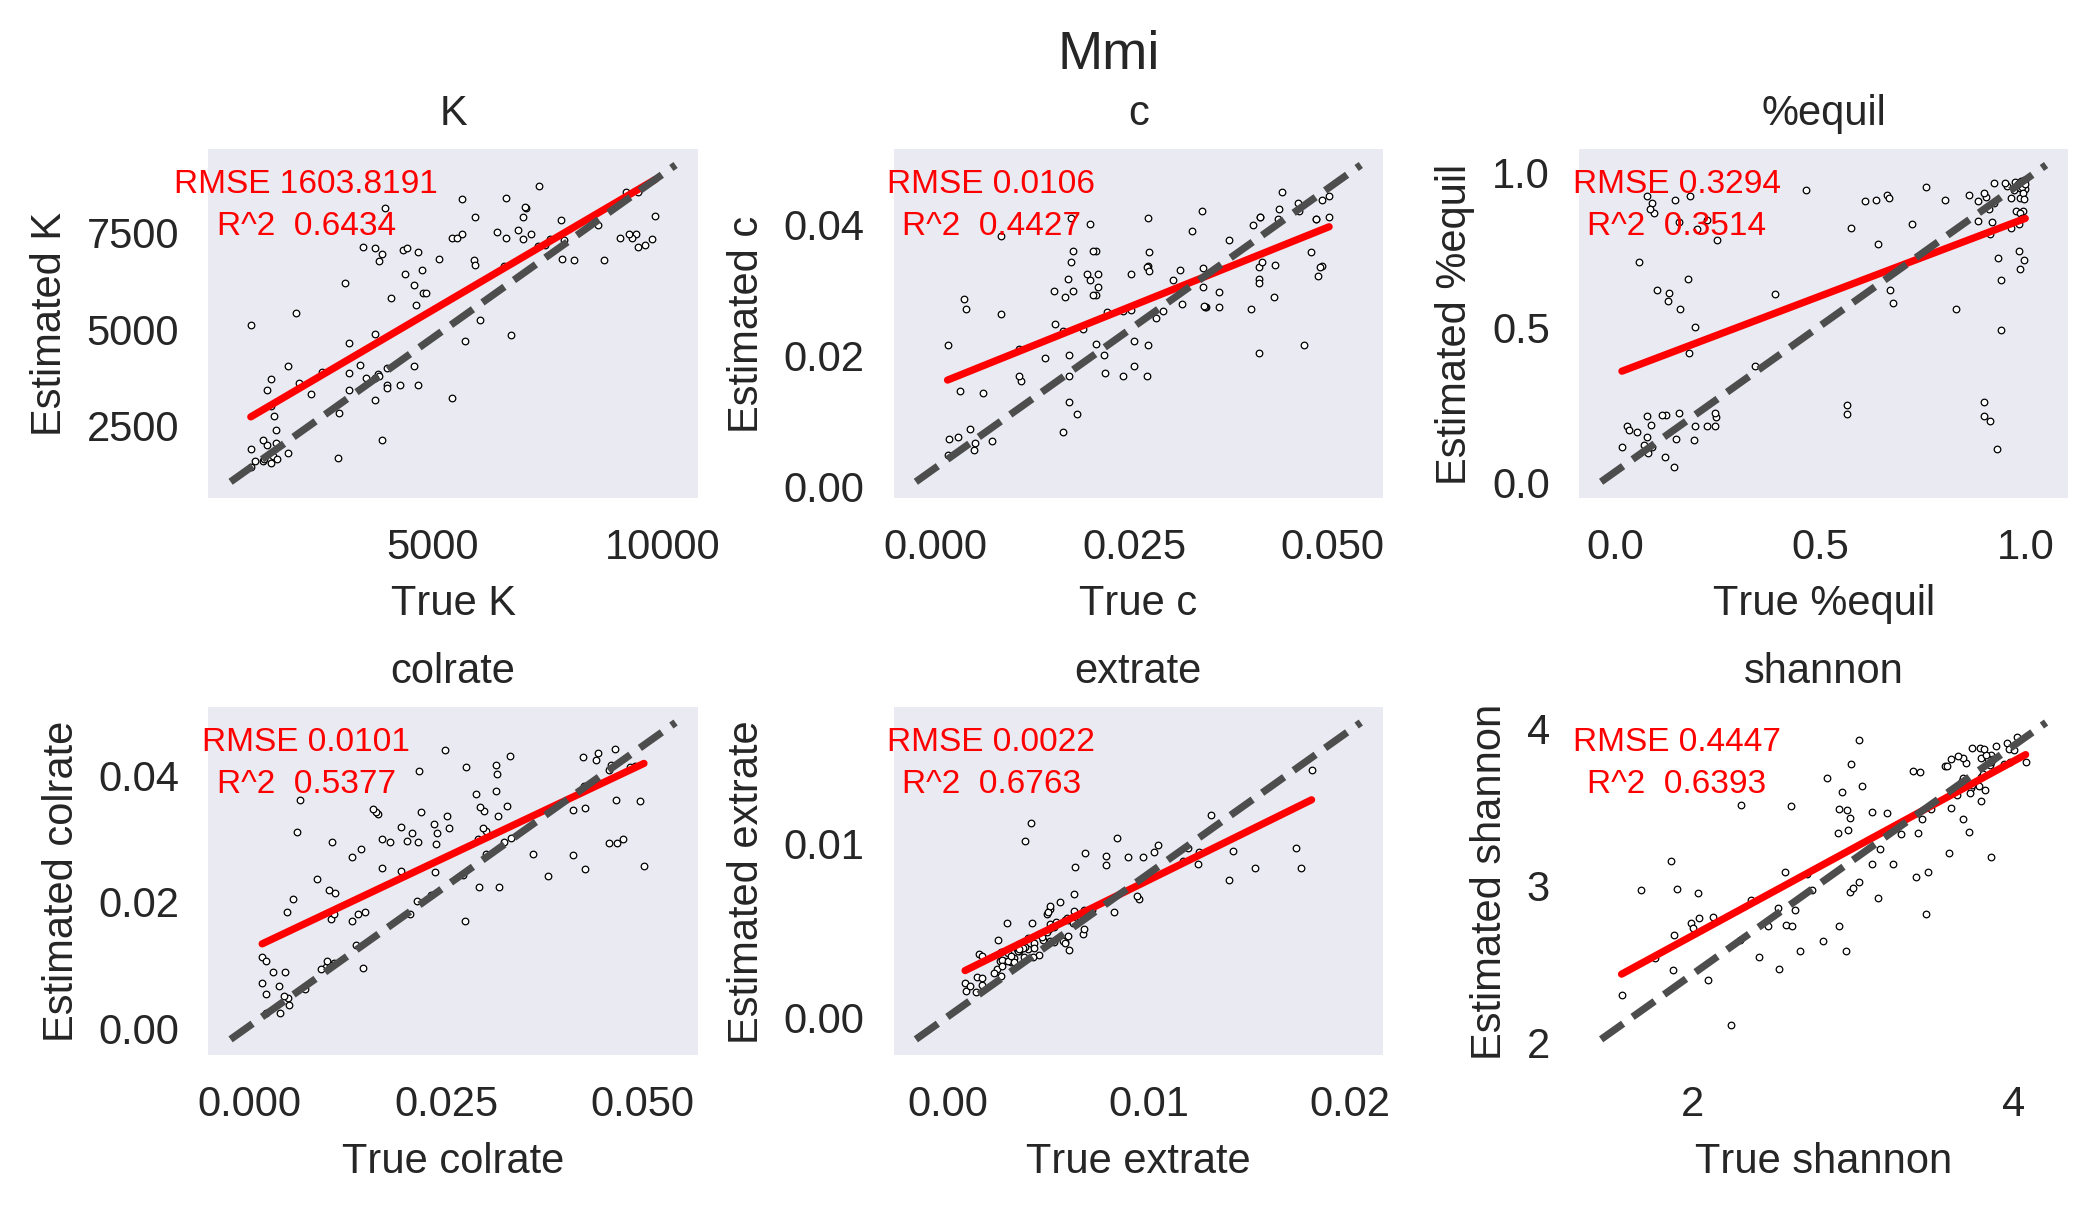

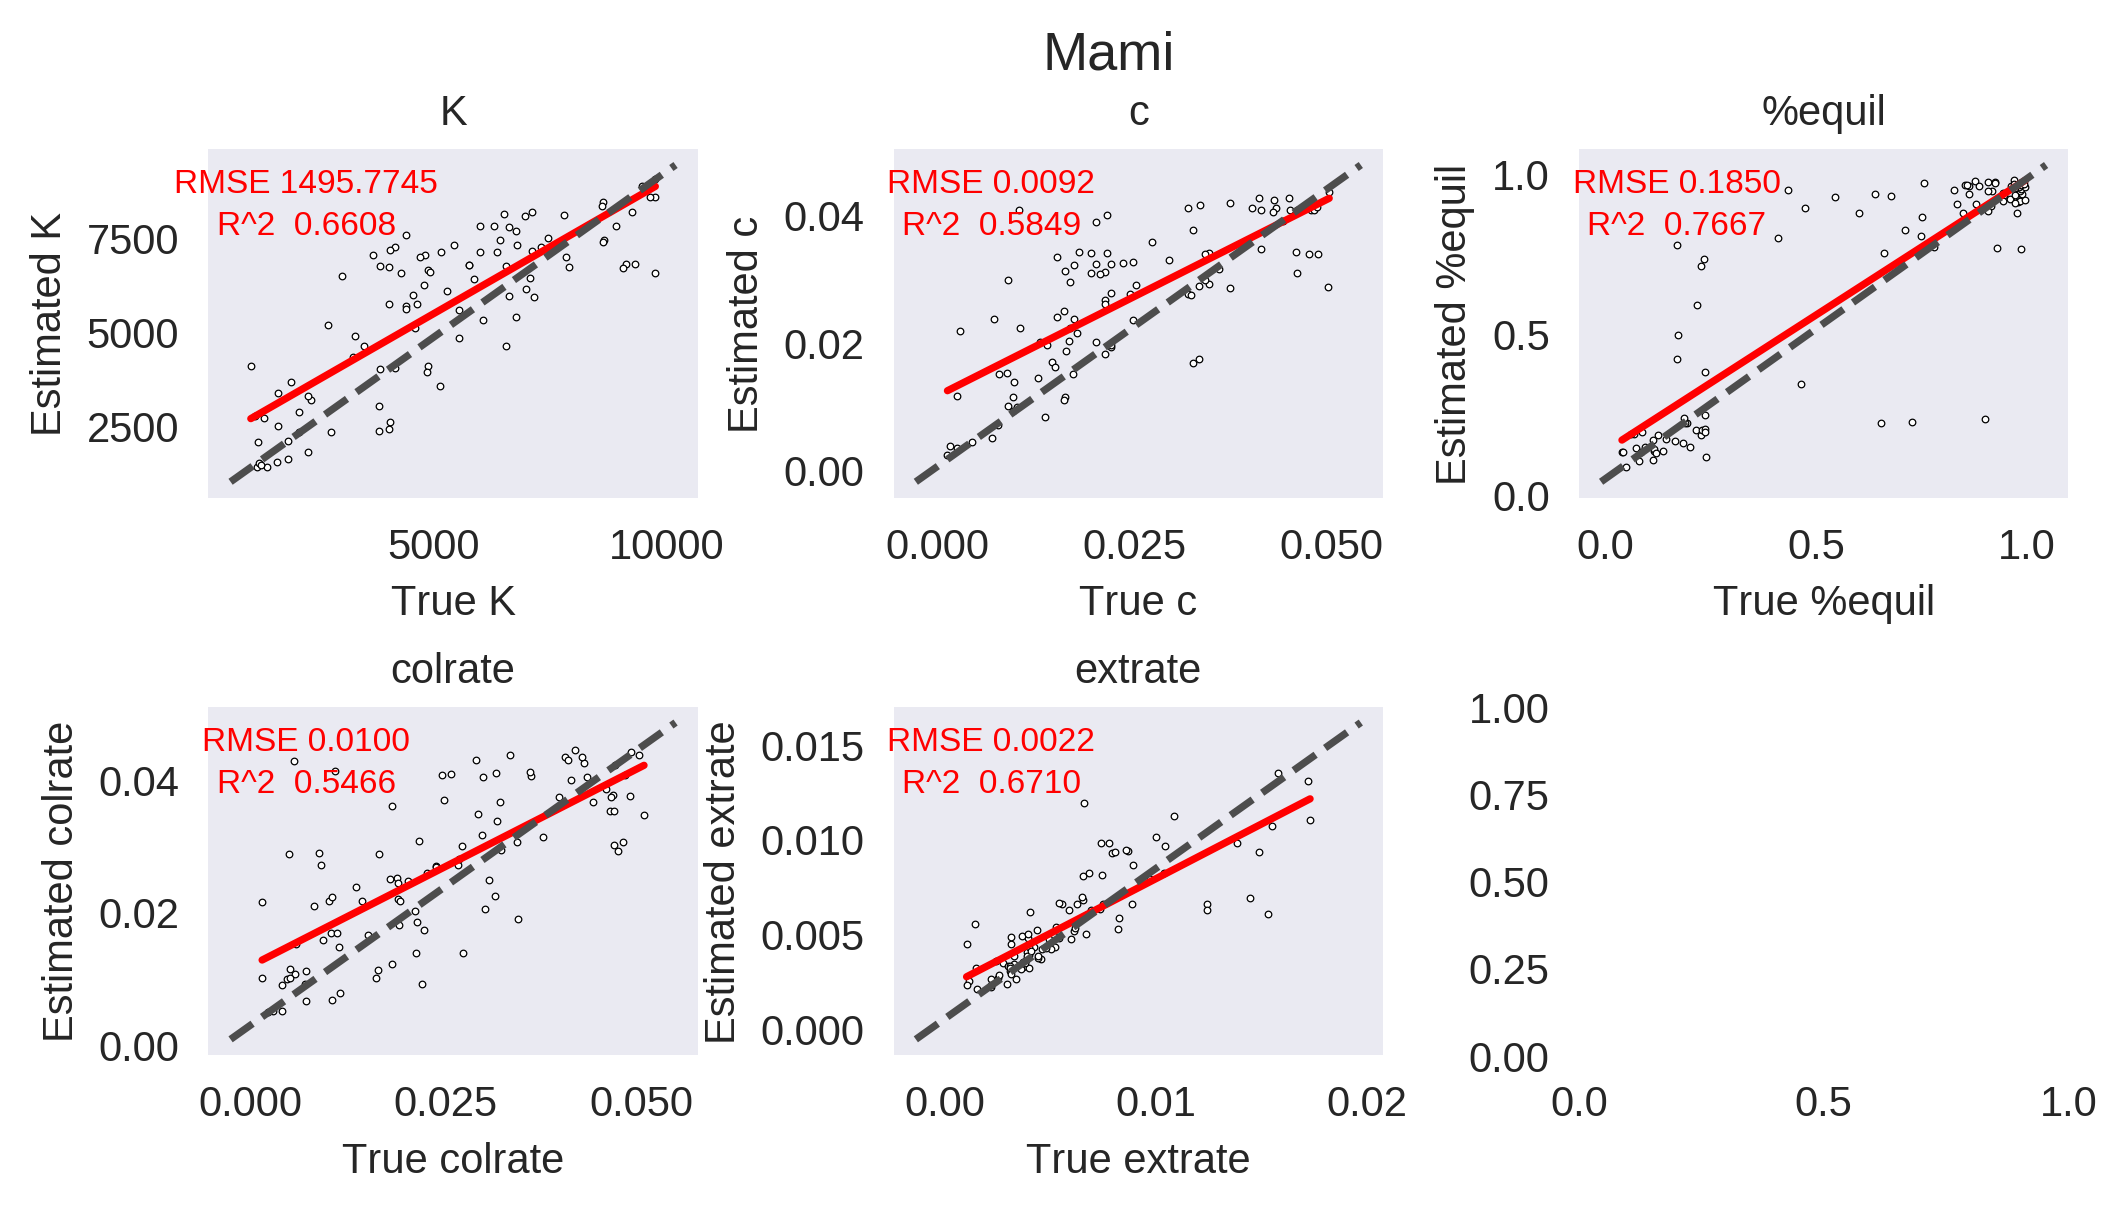

In [561]:
## Useful matplotlib style gallery
## https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
## https://matplotlib.org/examples/style_sheets/style_sheets_reference.html
import matplotlib.style as style
for model in models: #["Ma", "Mi"]:
    plot_cv(model, cv_dict)
    print("")

## Everything below here is crap

In [78]:
type(results_dict["Mai"]["c"])

pandas.core.frame.DataFrame

# Scenario M(I) - 1D SGD
## Estimate H' using 1D π vector

## Estimate Λ using 1D π pi vector

# Scenario M(MI) - 2D SGD

# Debugging ABC with NaN in the reference table due to 
# screwed up normalization. FUcKKKKkkK!

In [505]:
PRIOR = pd.read_csv("/home/isaac/gimmeSAD/2d_sims/priors.txt", sep="\t")[:2000]
print(len(PRIOR))
prior_args = model_args["Mami"][0:68]
print(prior_args)
cvresults = abc.cv4abc(PRIOR["c"], PRIOR[prior_args], nval=2, tols=robjects.r["c"](0.5), method="loclinear")
print(cvresults)

2000
['shannon', 'bin_0_0', 'bin_0_1', 'bin_0_2', 'bin_0_3', 'bin_0_4', 'bin_0_5', 'bin_0_6', 'bin_0_7', 'bin_0_8', 'bin_0_9', 'bin_1_0', 'bin_1_1', 'bin_1_2', 'bin_1_3', 'bin_1_4', 'bin_1_5', 'bin_1_6', 'bin_1_7', 'bin_1_8', 'bin_1_9', 'bin_2_0', 'bin_2_1', 'bin_2_2', 'bin_2_3', 'bin_2_4', 'bin_2_5', 'bin_2_6', 'bin_2_7', 'bin_2_8', 'bin_2_9', 'bin_3_0', 'bin_3_1', 'bin_3_2', 'bin_3_3', 'bin_3_4', 'bin_3_5', 'bin_3_6', 'bin_3_7', 'bin_3_8', 'bin_3_9', 'bin_4_0', 'bin_4_1', 'bin_4_2', 'bin_4_3', 'bin_4_4', 'bin_4_5', 'bin_4_6', 'bin_4_7', 'bin_4_8', 'bin_4_9', 'bin_5_0', 'bin_5_1', 'bin_5_2', 'bin_5_3', 'bin_5_4', 'bin_5_5', 'bin_5_6', 'bin_5_7', 'bin_5_8', 'bin_5_9', 'bin_6_0', 'bin_6_1', 'bin_6_2', 'bin_6_3', 'bin_6_4', 'bin_6_5', 'bin_6_6']
$calls
$calls$tol0.5
abc(target = target, param = param, sumstat = sumstat, tol = 0.5, 
    subset = subset, method = "loclinear", hcorr = TRUE, transf = "none", 
    logit.bounds = c(0, 0), kernel = NULL)


$cvsamples
[1]  994 1870

$tols
[1] 0.

In [506]:
%%R -i PRIOR,prior_args
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[prior_args]), PRIOR[,7], nval=2, tols=c(.5), method="rejection")
print(summary(cv.res.reg))
#plot(cv.res.reg)
#print(cv.res.reg)


Prediction error based on a cross-validation sample of 2

    eq.shannon eq.bin_0_0 eq.bin_0_1 eq.bin_0_2 eq.bin_0_3 eq.bin_0_4
0.5  0.1710794  0.3125000                                            
    eq.bin_0_5 eq.bin_0_6 eq.bin_0_7 eq.bin_0_8 eq.bin_0_9 eq.bin_1_0
0.5                                                         0.2699704
    eq.bin_1_1 eq.bin_1_2 eq.bin_1_3 eq.bin_1_4 eq.bin_1_5 eq.bin_1_6
0.5  0.1448137  0.2500000                                            
    eq.bin_1_7 eq.bin_1_8 eq.bin_1_9 eq.bin_2_0 eq.bin_2_1 eq.bin_2_2
0.5                                   0.5000000  0.5918367  1.0000000
    eq.bin_2_3 eq.bin_2_4 eq.bin_2_5 eq.bin_2_6 eq.bin_2_7 eq.bin_2_8
0.5        Inf                                                       
    eq.bin_2_9 eq.bin_3_0 eq.bin_3_1 eq.bin_3_2 eq.bin_3_3 eq.bin_3_4
0.5                                              1.0000000  1.0000000
    eq.bin_3_5 eq.bin_3_6 eq.bin_3_7 eq.bin_3_8 eq.bin_3_9 eq.bin_4_0
0.5                             

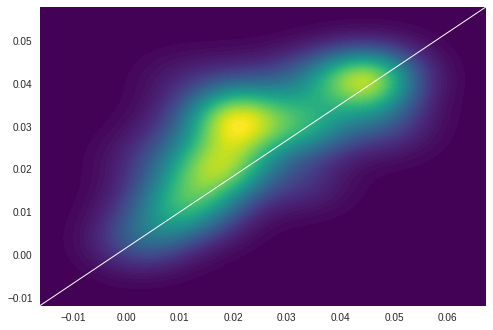

In [548]:
import seaborn as sns
x = cv_dict[model]["c"]["true"]
y = cv_dict[model]["c"]["estim"]

# cubehelix
ax = sns.kdeplot(x, y, n_levels=100, shade=True, shade_lowest=True, cmap="viridis")
ax.set_facecolor("black")
ax.grid(False)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="white", linewidth=1)